# Challenge: Boston Marathon
There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Model imports
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

# Cluster evalutations
from sklearn import metrics

In [132]:
results_2014 = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
results_2014.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [133]:
results_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [0]:
results_2014 = results_2014.drop('ctz', axis=1)

In [135]:
results_2014.nunique()

10k           2766
name         31915
division      6979
25k           6570
gender           2
age             64
official     11030
bib          31984
genderdiv    17575
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

In [0]:
results_2014 = results_2014.drop(['name', 'bib'], axis=1)
results_2014.gender = results_2014.gender.map(lambda x: 0 if x is 'F' else 1)

In [137]:
splits = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for dist in splits:
    results_2014[dist] = pd.to_numeric(results_2014[dist], errors='coerce')
    results_2014[dist] = results_2014[dist].map(lambda x: results_2013[dist].mean() if x is '-' else float(x))

results_2014.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,8,47.67,1,47,85.25,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [138]:
results_2014.country.value_counts().head(20)

USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
Name: country, dtype: int64

In [139]:
results_2014.state.value_counts().head(20)

MA    7587
CA    2326
NY    1553
ON    1052
PA    1001
TX     992
IL     916
OH     760
FL     750
VA     713
MI     695
NC     618
WA     596
CO     578
NJ     569
MN     556
MD     527
NH     526
CT     521
GA     443
Name: state, dtype: int64

In [140]:
results_2014.city.value_counts().head(20)

Boston           1034
New York          498
Chicago           313
Cambridge         311
Somerville        240
Toronto           240
Brookline         222
Washington        212
Newton            201
Austin            192
San Francisco     192
Portland          191
Arlington         184
San Diego         182
Brighton          151
Seattle           149
Charlestown       148
Houston           138
London            135
Quincy            134
Name: city, dtype: int64

In [0]:
X = results_2014.drop(['country', 'city', 'state'], axis=1)


We normalize the data, then create a two-feature PCA.

In [142]:
X = X.drop(X.index[0])
Xn = normalize(X.dropna(axis=0, how='any'))
print(len(Xn))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xn)

31648


We separate the data into four equal sets for cross validation.

In [143]:
# Divide into two sets.
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(Xn, X_pca, test_size=0.5, random_state=42)

# Dividing into four sets
X1, X2, X_pca1, X_pca2 = train_test_split(Xhalf1, X_pca_1, test_size=0.5, random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(Xhalf2, X_pca_1, test_size=0.5, random_state=42)

# Checking the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7912 7912


# K Means Modeling
We create two data frames, one for the y predictions from a K-means model, and another silhouette scores for the different clusters. Later, we fit the model for 2 to 5 clusters, calculating silhouette scores for each.

In [0]:
# Initialize data frames
ypred = pd.DataFrame()
score = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
       
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=nclust, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore}, ignore_index=True)

In [146]:
# Sorting sihoilette scores
score.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,sil_score,silhouette_score
14,clust4_sample3,NaN,0.497272
6,clust4_sample1,NaN,0.495845
2,clust4_sample0,NaN,0.494896
10,clust4_sample2,NaN,0.493773
13,clust3_sample3,NaN,0.482041
1,clust3_sample0,NaN,0.480960
9,clust3_sample2,NaN,0.475093
5,clust3_sample1,NaN,0.473798
4,clust2_sample1,NaN,0.458424
7,clust5_sample1,NaN,0.453836


A four-cluster system has the highest silhouette scores.

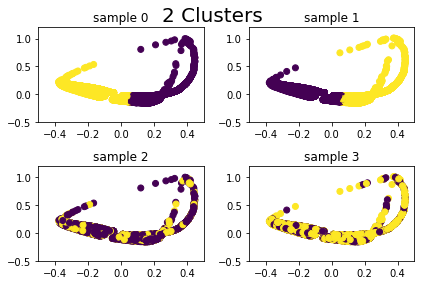

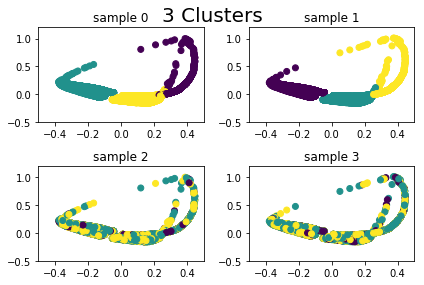

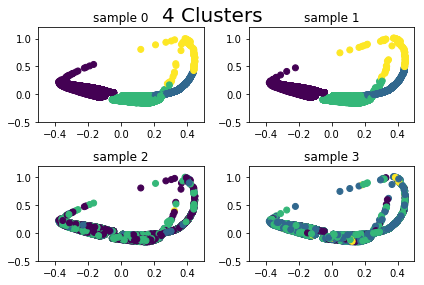

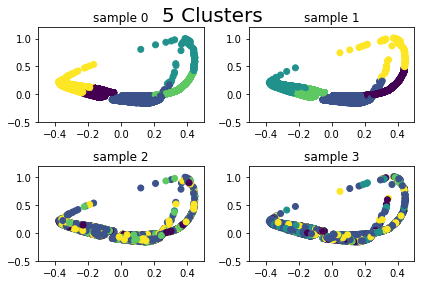

In [147]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Watching the plots of the 2-feature PCA data, all clusters are inconsistent across samples 2 and 3. However, the 4-cluster solution is most consistent across samples 0 and 1.

# Mean Shift
For a mean shift model, we will use a range of quantiles to create bandwidths from 0.1 to 0.4, calculating the Silhouette scores for each.

In [0]:
# Initialize new data frames
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['cluster_pred','mean_shift', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        # Ensuring all sets are the same lenght
        data = data[:4013][:]
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms['clust' + str(cntrs) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'cluster_pred':'clust' + str(cntrs) + '_sample' + str(counter), 
                              'silhouette_score':sscore, 'quantile':n}, ignore_index=True)

In [149]:
score_ms.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,mean_shift,quantile,silhouette_score
8,clust13_sample2,NaN,0.1,0.521268
13,clust5_sample3,NaN,0.2,0.520134
1,clust3_sample0,NaN,0.2,0.513119
6,clust5_sample1,NaN,0.3,0.507805
9,clust5_sample2,NaN,0.2,0.495607
14,clust4_sample3,NaN,0.3,0.490779
2,clust5_sample0,NaN,0.3,0.490357
11,clust4_sample2,NaN,0.4,0.485879
3,clust6_sample0,NaN,0.4,0.481921
10,clust5_sample2,NaN,0.3,0.481537


The quantile of 0.1 calculated a high Silhouette score for sample 2 and generated 13 clusters.

# Spectral Clustering
For the spectral clustering model, we use a range of clusters from 2 to 5, and we calculate the corresponding Silhouette scores for each.

In [0]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [151]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
15,clust5_sample3,0.496570
7,clust5_sample1,0.494029
3,clust5_sample0,0.493891
14,clust4_sample3,0.492555
11,clust5_sample2,0.492199
6,clust4_sample1,0.489489
2,clust4_sample0,0.488364
10,clust4_sample2,0.486623
4,clust2_sample1,0.468549
0,clust2_sample0,0.456565


A 5 cluster configuration generates the highest silhouette score.

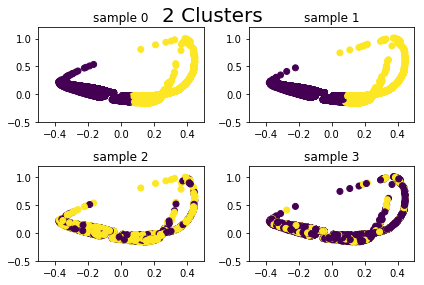

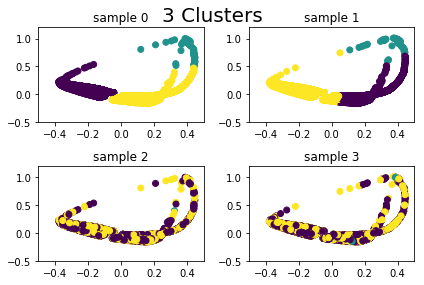

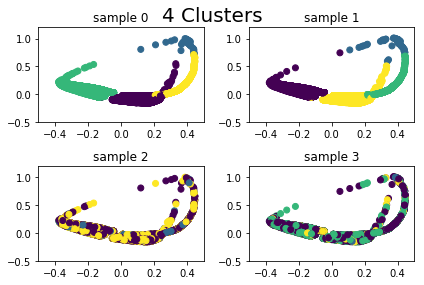

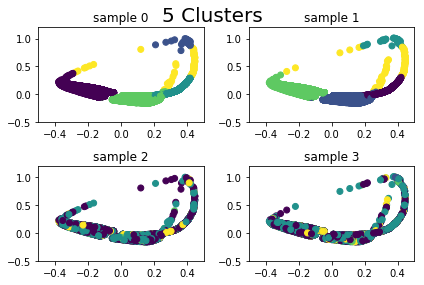

In [152]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_sc['pca_f1_sample{}'.format(i)]
        y_sub = ypred_sc['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_sc['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

# Affinity Propagation
For the Affinity Propagation model, we allow the model to find the k-number of clusters and calculate the corresponding Silhouette scores for each.

In [0]:
# Initialize data frames
ypred = pd.DataFrame()
score_af = pd.DataFrame(columns=['cluster_pred','AF'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Ensuring all sets are the same lenght
    data = data[:4013][:]
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    #pred = af.fit_predict(data)
    #ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    # Calculating silhouette scores for the data and adding that to the shilouette score
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'cluster_pred':'clust' + str(n_clusters_) + '_sample' + str(counter), 
                              'AF':sscore_af}, ignore_index=True)

In [154]:
score_af.sort_values(by='AF', ascending=False)

,cluster_pred,AF
2,clust1912_sample2,0.136355
3,clust2706_sample3,0.103609
1,clust3075_sample1,0.085921
0,clust3175_sample0,0.081697


The number of clusters generated is too large and the highest score is very low, suggesting it isn't reliable.

# Conclusion
Overall, the 5 cluster solution has the highest consistent Silhouette scores across the various models. The mean shift model generated the highest Silhouette score with a value at 0.521. This drives us to the conclusion that the are 5 main group of runners in this marathon. The following information corresponds to results obtained using the K-means model and 5 clusters:

In [0]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(Xn)

In [0]:
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']

In [213]:
# Add the outcome back onto X
combined = X.join(df_y, how='inner')
combined.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,Cluster
1,32.58,1,82.43,0,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,3
2,16.62,1,45.80,1,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,3
3,32.57,3,82.43,0,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,3
4,17.12,2,46.37,1,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,3
5,32.58,4,82.45,0,29,140.68,4,116.37,28,5.37,99.33,16.22,69.47,65.83,132.95,3


In [0]:
# Create age buckets

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [0]:
combined['Age Bucket'] = combined['age'].apply(lambda x: age_bucket(x))

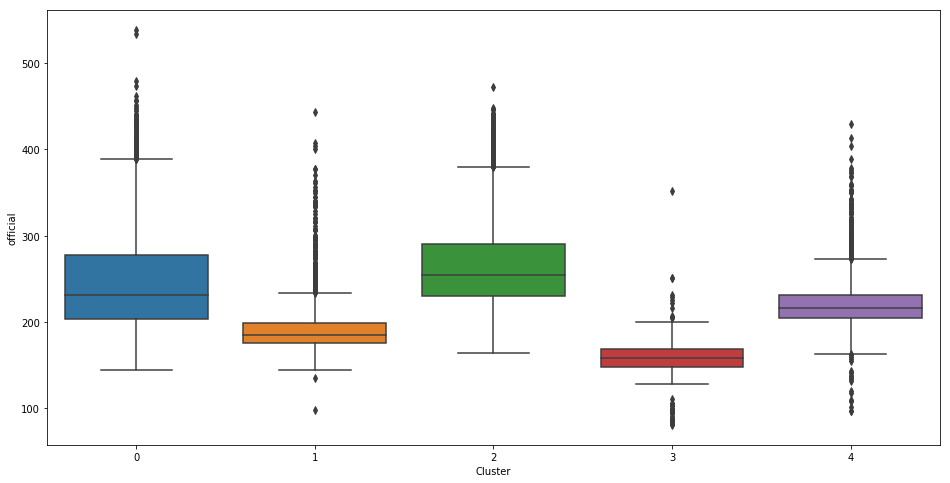

In [216]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster',y='official',data=combined)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


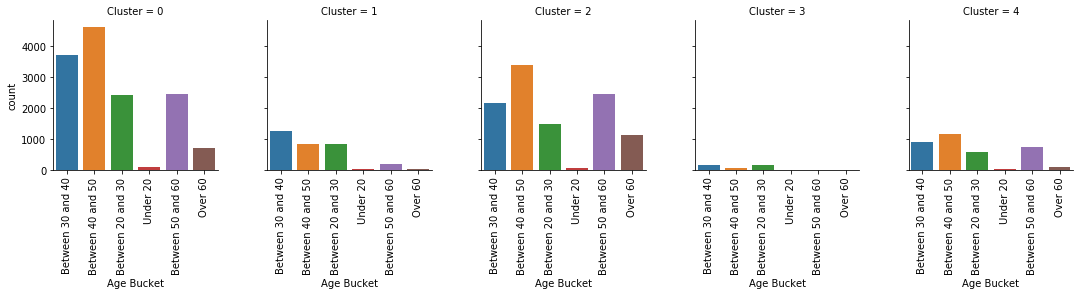

In [227]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='Age Bucket', col='Cluster', kind="count", data=combined, size=3)
g.set_xticklabels(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


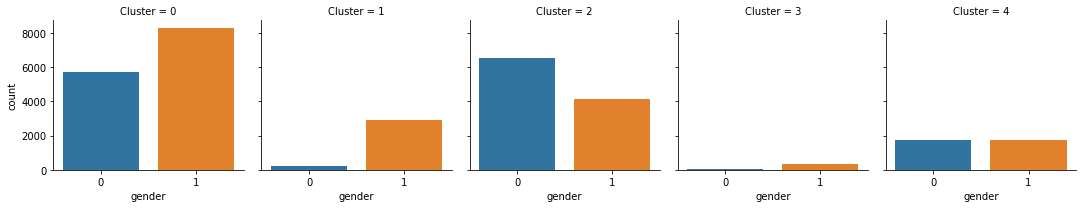

In [226]:
sns.factorplot(x='gender', col='Cluster', kind="count", data=combined, size=3)

In [0]:
# Separate the clusters
cluster0 = combined[combined['Cluster']==0]
cluster1 = combined[combined['Cluster']==1]
cluster2 = combined[combined['Cluster']==2]
cluster3 = combined[combined['Cluster']==3]
cluster4 = combined[combined['Cluster']==4]

In [220]:
# check Gender Breakdown
cluster0['gender'].value_counts()

1    8332
0    5719
Name: gender, dtype: int64

In [221]:
cluster1['gender'].value_counts()

1    2889
0     216
Name: gender, dtype: int64

In [222]:
cluster2['gender'].value_counts()

0    6524
1    4136
Name: gender, dtype: int64

In [223]:
cluster3['gender'].value_counts()

1    314
0     51
Name: gender, dtype: int64

In [224]:
cluster4['gender'].value_counts()

1    1739
0    1727
Name: gender, dtype: int64